# Analysis

Read data files from multiple chillers and create a model

In [608]:
import pandas as pd
import numpy as np

from sklearn.linear_model    import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model    import RidgeCV
from sklearn.pipeline        import make_pipeline
from sklearn.preprocessing   import PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.preprocessing   import StandardScaler
from sklearn.metrics         import mean_squared_error
from sklearn.linear_model    import Lasso
from sklearn                 import linear_model

import seaborn as sns
import matplotlib.pyplot as plt

from math import sqrt

%matplotlib inline

In [620]:
df1 = pd.read_csv('data/S1_chiller.csv')
df2 = pd.read_csv('data/S2_chiller.csv')
df3 = pd.read_csv('data/S3_chiller.csv')
df4 = pd.read_csv('data/S4_chiller.csv')

In [ ]:
df1.columns

In [621]:
def clean_NaN(df):
    # Look for rows with NaN and drop
    print(df[df['Load'].isnull() == True])
    print(df[df['DTLift'].isnull() == True])
    print(df[df['kW/Ton'].isnull() == True])
      
    # drop rows with NaN
    df.dropna(subset=['Load','DTLift','kW/Ton'],inplace=True)
    return df

In [622]:
df1 = clean_NaN(df1)
df2 = clean_NaN(df2)
df3 = clean_NaN(df3)
df4 = clean_NaN(df4)

      Unnamed: 0                   datetime    kW/Ton  Load      CDWRT  \
1          10498  2018-02-06 10:50:00+00:00  0.439113   NaN  67.000000   
2          10499  2018-02-06 10:55:00+00:00  0.449366   NaN  72.699997   
3          10500  2018-02-06 11:00:00+00:00  0.466974   NaN  74.400002   
1371       11868  2018-02-11 05:00:00+00:00       NaN   NaN  67.199997   

          CDWST     DTLift          Ton  EvapApproach  CondApproach  \
1     55.500000  16.200001  1976.712574      1.399998      1.699997   
2     61.200001  21.399998  1902.682094      1.500000      1.700005   
3     63.299999  23.300003  1830.936228      1.500000      1.199997   
1371  67.400002  16.999996          NaN      5.700001     -6.199997   

             Hz     CompSH    IGV     REFLVL  
1     59.980000  23.400002  100.0  56.400002  
2     59.290001  20.400002  100.0  95.000000  
3     59.290001  16.300003  100.0  50.000000  
1371  35.119999  18.900002    0.0   2.000000  
Empty DataFrame
Columns: [Unnamed: 0, 

In [720]:
def plot_curves(df,lift_lines=None,title=''):
    plt.figure(figsize=(12,7))

    col_list = { 10:'blue',
                 20:'red',
                 30:'green',
                 40:'yellow',
                 50:'purple'
               }
    # set the colors for the lift points
    def pltcolor(lift,col_list):
        cols=[]
        for l in lift:
            if l <= 15:
                cols.append(col_list[10])
            elif (l > 15) and (l <= 25):
                cols.append(col_list[20])
            elif (l > 25) and (l <= 35):
                cols.append(col_list[30])
            elif (l > 35) and (l <= 45):
                cols.append(col_list[40])
            elif (l > 45):
                cols.append(col_list[50])
        return cols

    # if there is predicted lift lines, plot these
    if lift_lines:
        for key in lift_lines:
            x_line = lift_lines[key][0]
            y_line = lift_lines[key][1]
#             line_pts = lift_lines[key]
#             x_line, y_line = list(zip(*line_pts)).copy()
            plt.plot(x_line,y_line,c='white',linewidth=3.0)            
            plt.plot(x_line,y_line,c=col_list[key],linewidth=1.0,label=f'{key} degrees F Lift')
            
    # call function to set the bands of colors
    bands = pltcolor(list(df['DTLift']),col_list)

    plt.scatter(x=df['Load'],y=df['kW/Ton'],s=2,c=bands,label='')
    plt.legend(fontsize=15)
    plt.xlabel('Load',size=20)
    plt.ylabel('kW/Ton',size=20)
    plt.title(title, size=20)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.grid(True)
    plt.ylim(0,1)
    plt.xlim(0,1)
    plt.show()


No handles with labels found to put in legend.


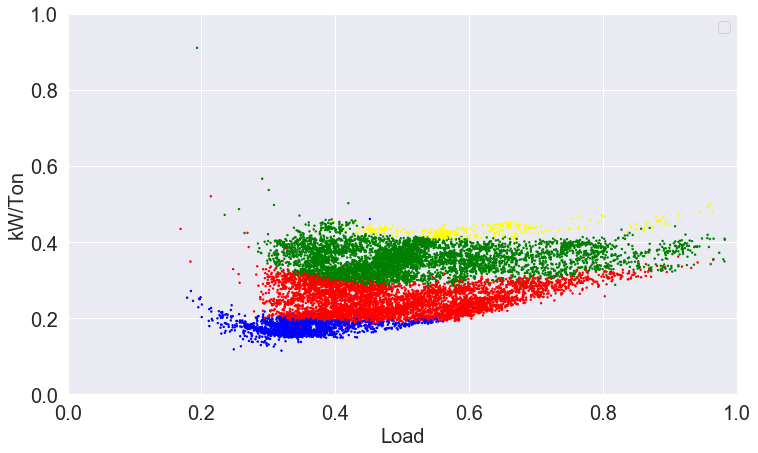

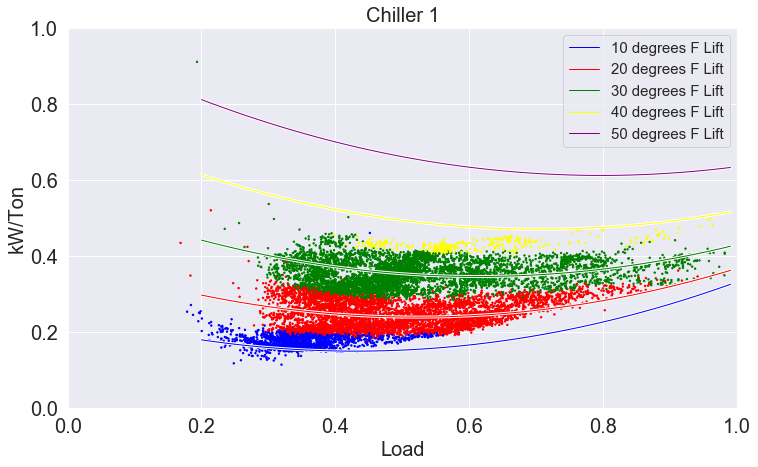

In [721]:
plot_curves(df1)
plot_curves(df1,lift_lines,'Chiller 1')

## set up X and y

In [623]:
def get_Xy(df,features=[]):
    y = df['kW/Ton']
    X = df[['Load','DTLift']]

    if 'HigherOrder' in features:
        X['Load^2'] = df['Load']**2
        X['DTLift^2'] = df['DTLift']**2
        X['Load*DTLift'] = df['Load']*df['DTLift']
    if 'AddOther' in features:    
        X['CompSH'] = df['CompSH']
        X['EvapApproach'] = df['EvapApproach']
        X['CondApproach'] = df['CondApproach']
        X['IGV'] = df['IGV']
        X['REFLVL'] = df['REFLVL']

    return (X, y)

In [470]:
df1.columns

Index(['Unnamed: 0', 'datetime', 'kW/Ton', 'Load', 'CDWRT', 'CDWST', 'DTLift',
       'Ton', 'EvapApproach', 'CondApproach', 'Hz', 'CompSH', 'IGV', 'REFLVL'],
      dtype='object')

In [527]:
X, y = get_Xy(df1)

#divide in to train and test sets
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.4,random_state=42)
print(X_train.shape, y_train.shape)

(8563, 2) (8563,)


In [624]:
#feat = ['AddOther','HigherOrder']
feat = ['HigherOrder']

X_train, y_train = get_Xy(df1,feat)
print('df1:',X_train.shape,y_train.shape)
X2_test, y2_test = get_Xy(df2,feat)
print('df2:',X2_test.shape,y2_test.shape)
X3_test, y3_test = get_Xy(df3,feat)
print('df3:',X3_test.shape,y3_test.shape)
X4_test, y4_test = get_Xy(df4,feat)
print('df4:',X4_test.shape,y4_test.shape)


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#index

df1: (14272, 5) (14272,)
df2: (5465, 5) (5465,)
df3: (3839, 5) (3839,)
df4: (13706, 5) (13706,)


## Linear Regression

In [401]:
'''
# Using statsmodels

import statsmodels.api as sm

# Note the difference in argument order
model = sm.OLS(y_train, X_train).fit()
predictions = model.predict(X_train) # make the predictions by the model

# Print out the statistics
model.summary()

print(model.params)
'''

Load      0.942141
Load^2   -0.869288
dtype: float64


In [612]:
# Create an empty model
lr = LinearRegression()

# Fit the model to the full dataset
lr.fit(X_train, y_train)

# Print out the R^2 for the model against the full dataset
lr.coef_
lr.score(X_train,y_train)

0.9824698009878725

In [613]:
print('test with S2: ',lr.score(X2_test,y2_test))
print('test with S3: ',lr.score(X3_test,y3_test))
print('test with S4: ',lr.score(X4_test,y4_test))

test with S2:  0.6125398036843765
test with S3:  0.6398119077069954
test with S4:  0.9727378099214362


In [714]:
df1.columns

Index(['Unnamed: 0', 'datetime', 'kW/Ton', 'Load', 'CDWRT', 'CDWST', 'DTLift',
       'Ton', 'EvapApproach', 'CondApproach', 'Hz', 'CompSH', 'IGV', 'REFLVL'],
      dtype='object')

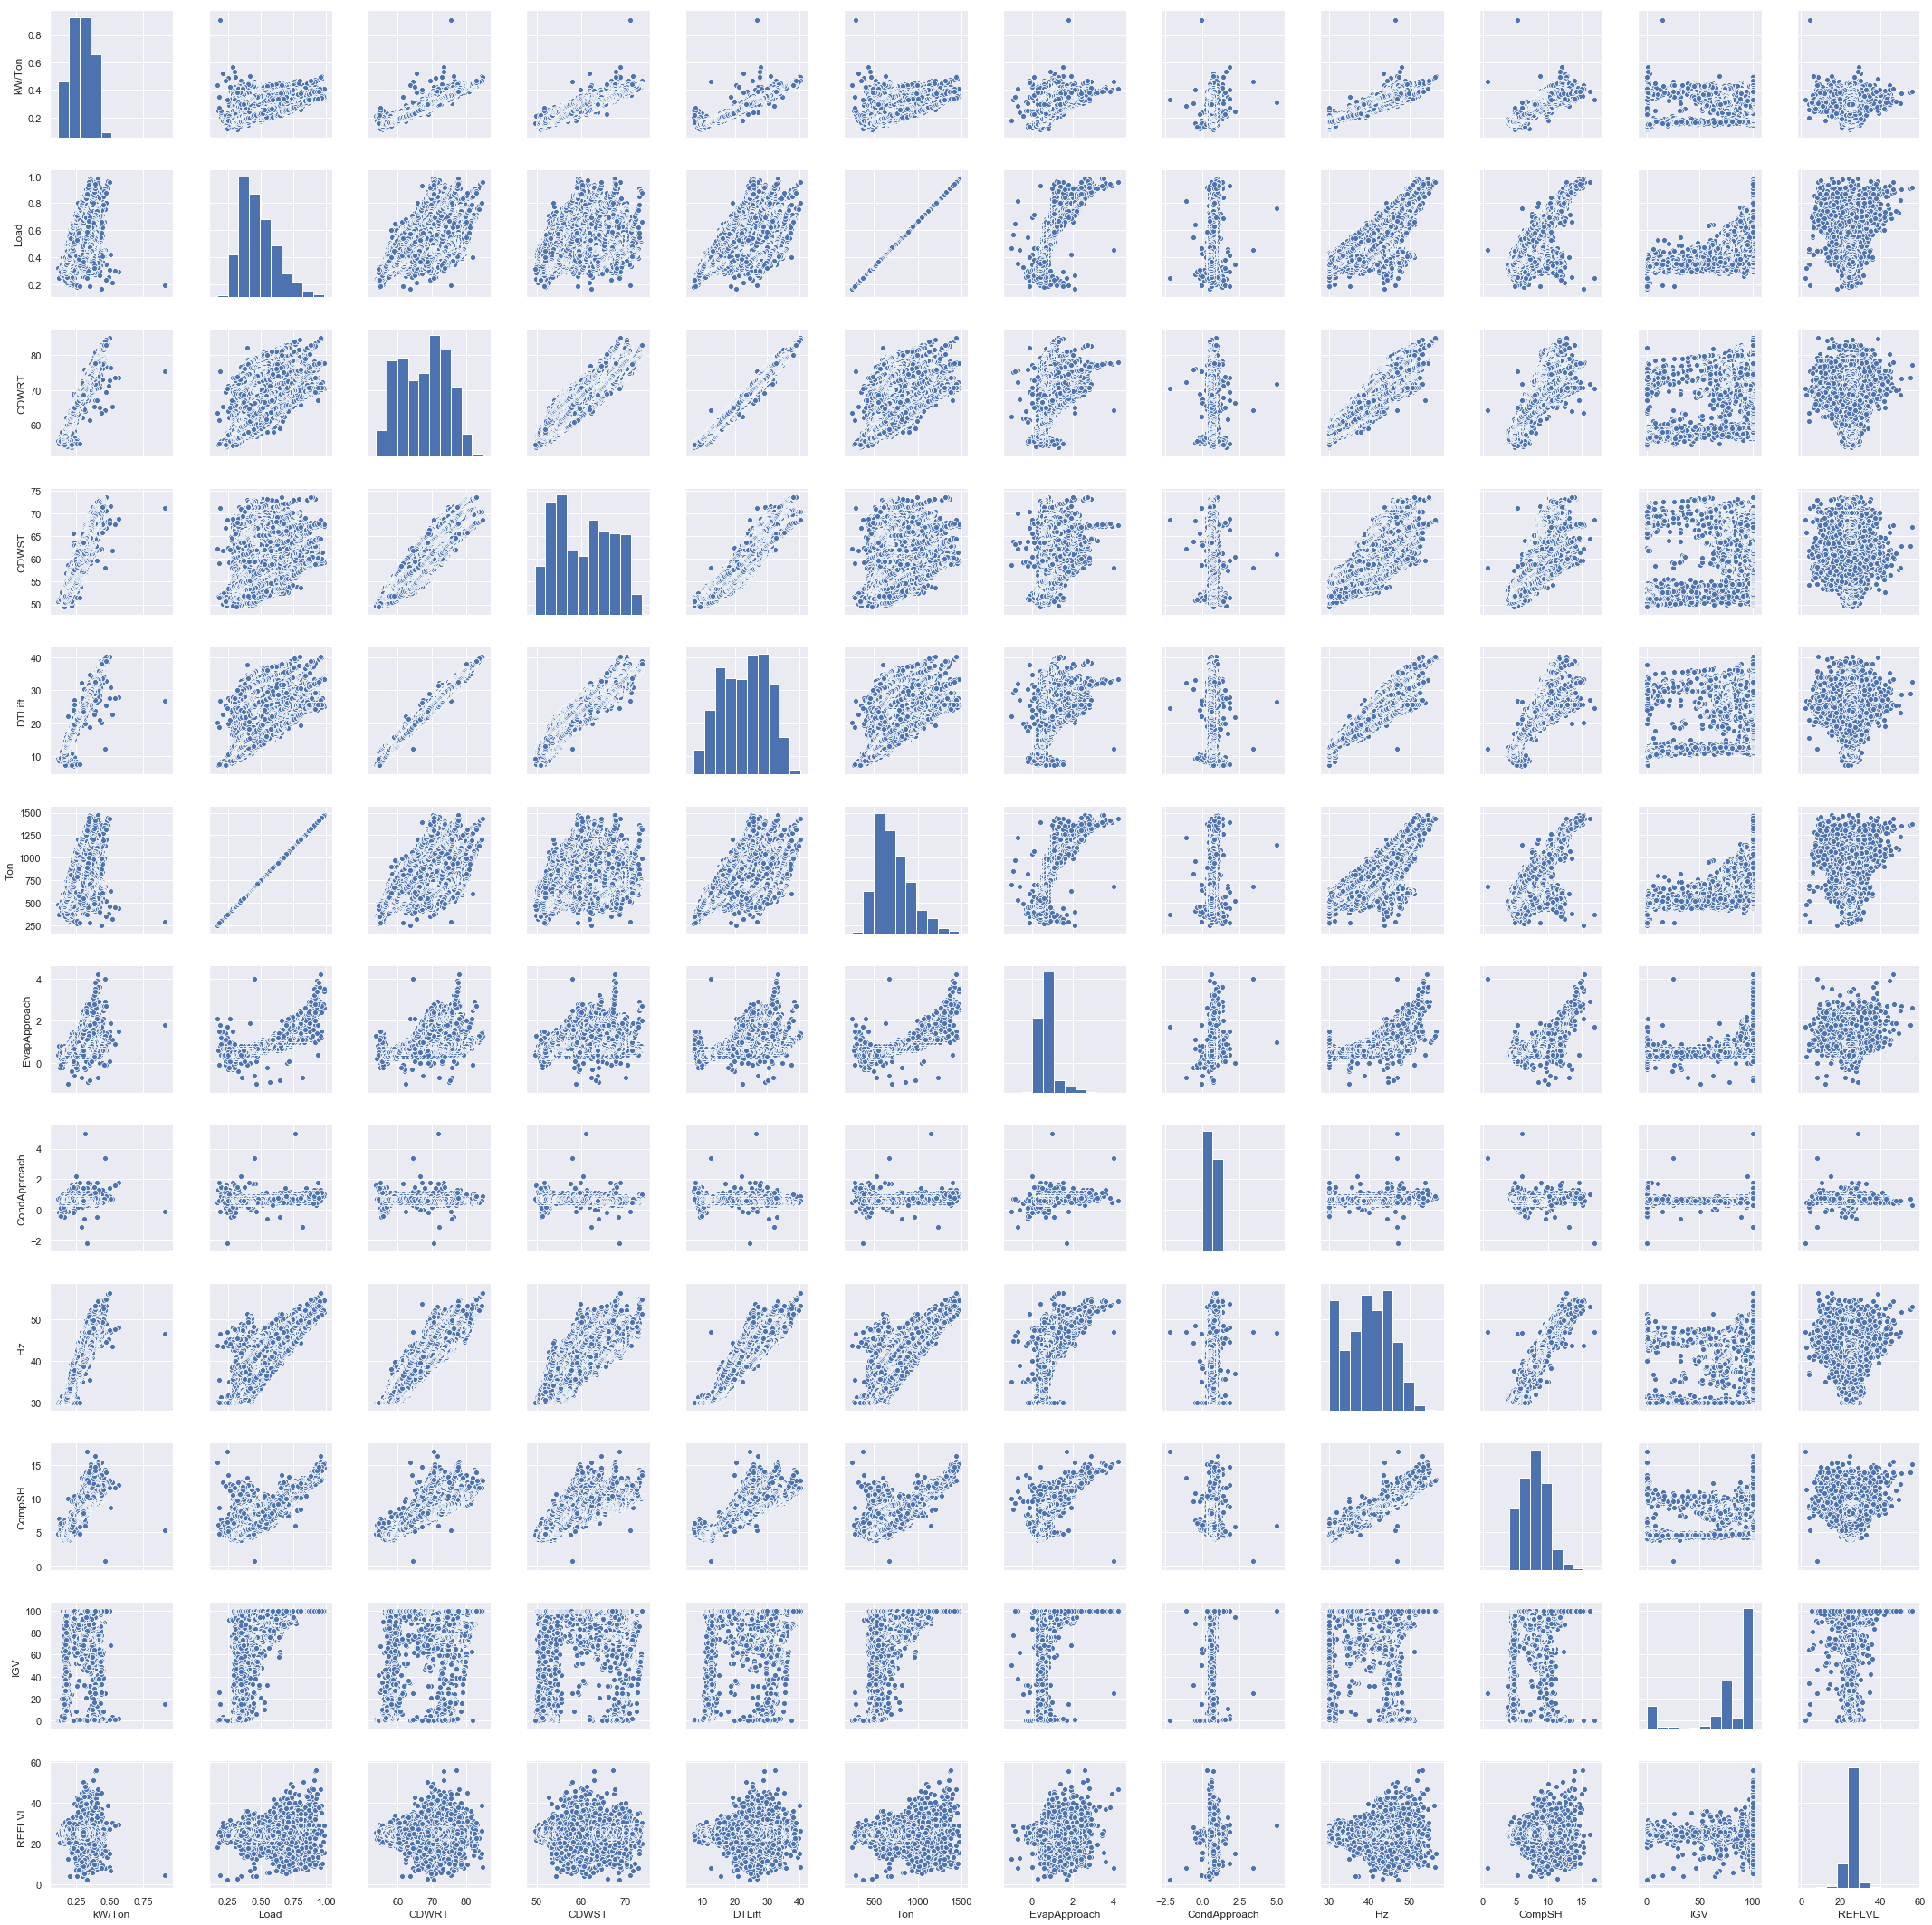

In [715]:
import seaborn as sns
df1.drop(columns=['Unnamed: 0'],inplace=True)
sns.pairplot(df1)

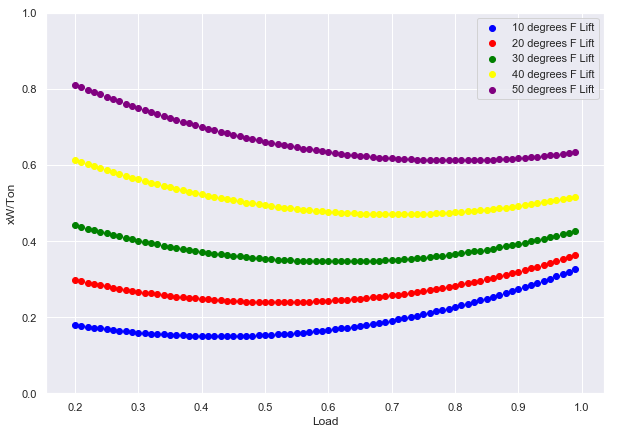

In [615]:
col_list = ['blue','red','green','yellow','purple']
lift_lines = {}
plt.figure(figsize=(10,7))

features=['HigherOrder']

X_line = pd.DataFrame()
for lift in range(10,60,10):
    X_line['Load'] = np.arange(0.2,1,0.8/80)
    X_line['DTLift'] = lift*np.ones(80)
    if 'HigherOrder' in features:
        X_line['Load^2'] = X_line['Load']**2
        X_line['DTLift^2'] = X_line['DTLift']**2
        X_line['Load*DTLift'] = X_line['Load']*X_line['DTLift']
    if 'AddOther' in features:    
        X_line['CompSH'] = df['CompSH']
        X_line['EvapApproach'] = df['EvapApproach']
        X_line['CondApproach'] = df['CondApproach']
        X_line['IGV'] = df['IGV']
        X_line['REFLVL'] = df['REFLVL']  
    
    y_line = lr.predict(X_line)
    
#    lift_lines[lift] = zip(X_line['Load'].copy(),y_line.copy())
    lines = []
    lines.append(X_line['Load'])
    lines.append(y_line)
    lift_lines[lift] = lines

    plt.scatter(list(X_line['Load']),y_line,c=col_list[0],label=f'{lift} degrees F Lift')
    col_list.pop(0)

    
plt.ylim(0,1)
plt.legend()
plt.xlabel('Load')
plt.ylabel('xW/Ton')
plt.grid(True)



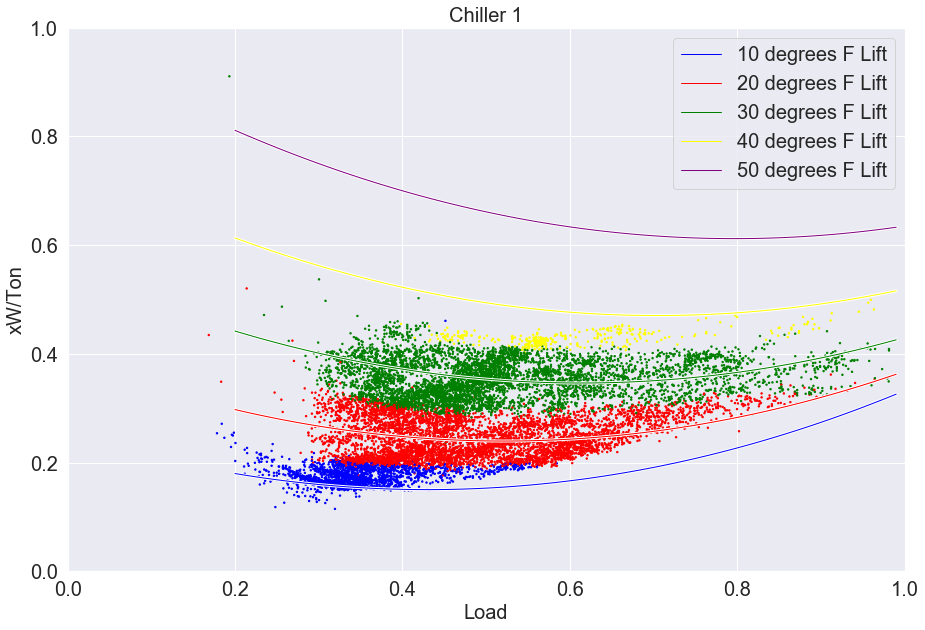

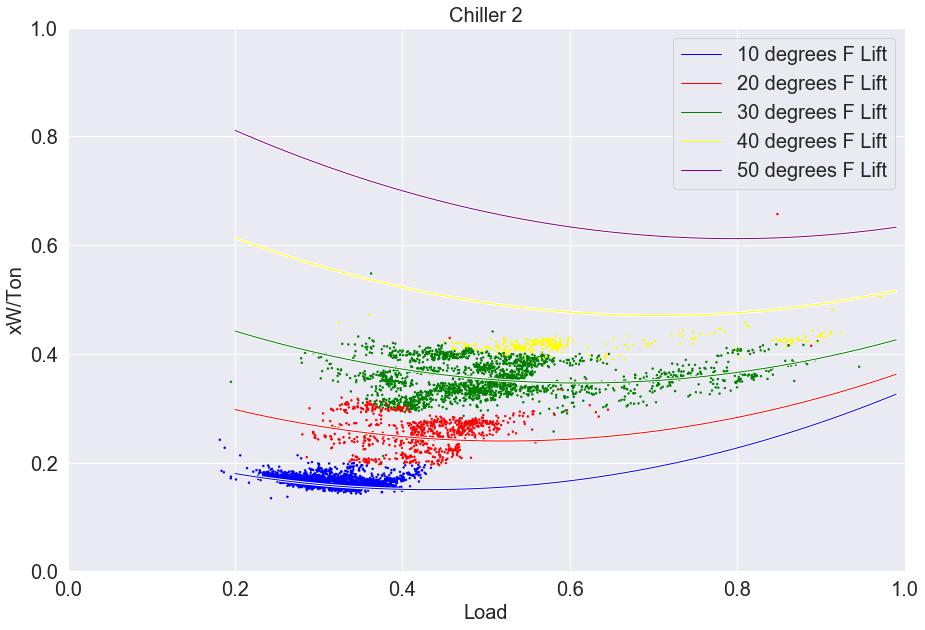

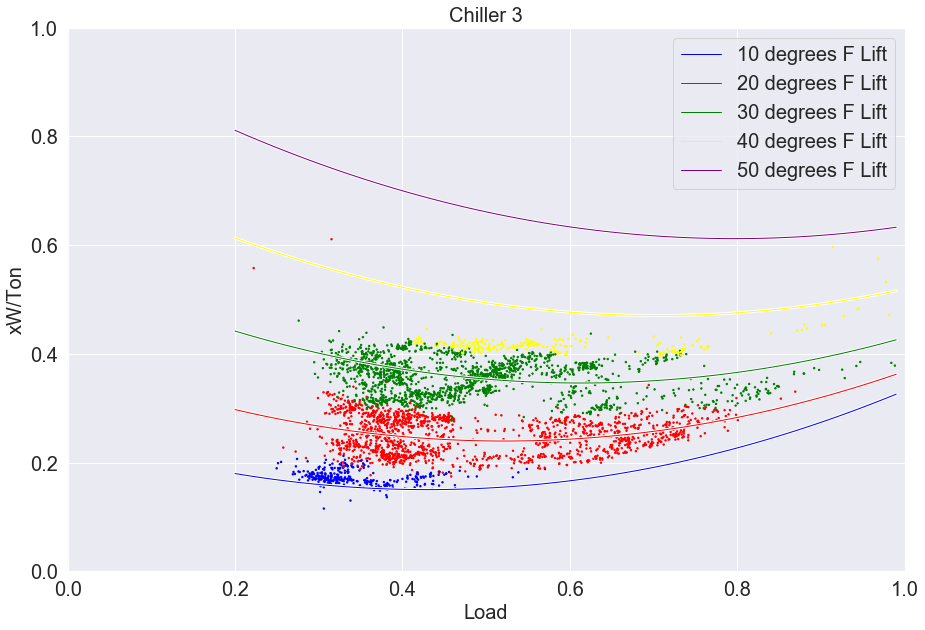

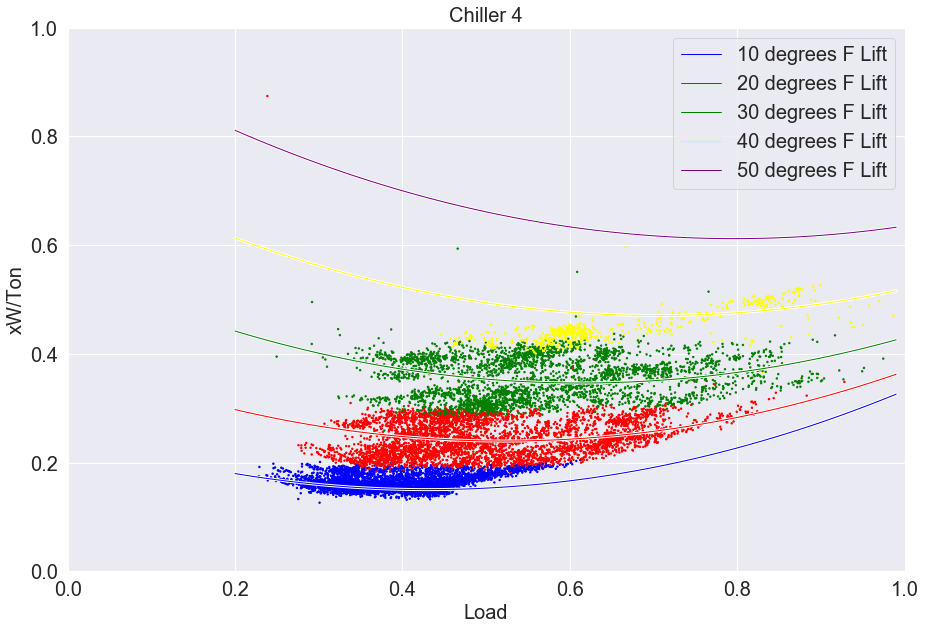

In [709]:

plot_curves(df1,lift_lines,'Chiller 1')
plot_curves(df2,lift_lines,'Chiller 2')
plot_curves(df3,lift_lines,'Chiller 3')
plot_curves(df4,lift_lines,'Chiller 4')

## LASSO

In [616]:
lr_lasso = linear_model.Lasso(alpha=0.1)
lr_fit = lr_lasso.fit(X_train, y_train)

# Print out the R^2 for the model against the full dataset
lr_lasso.score(X_train,y_train)

0.9544379541865223

In [685]:
#alpha_list = [1e-4, 1e-3, 1e-2, .05, 1e-1,.3,.5,.7]
alpha_list = [1e-4,5e-4,1e-3,5e-3,1e-2,5e-2]

lasso_results = []
for alpha in alpha_list:
    lr_lasso = linear_model.Lasso(alpha=alpha)
    lr_lasso_fit = lr_lasso.fit(X_train, y_train)

    score = lr_lasso.score(X_train,y_train)
    RMSE = sqrt(mean_squared_error(y2_test, lr_lasso.predict(X2_test)))
    coef = lr_lasso_fit.coef_.tolist()
    #print(coef)
    lasso_results.append([alpha,score,coef,RMSE])

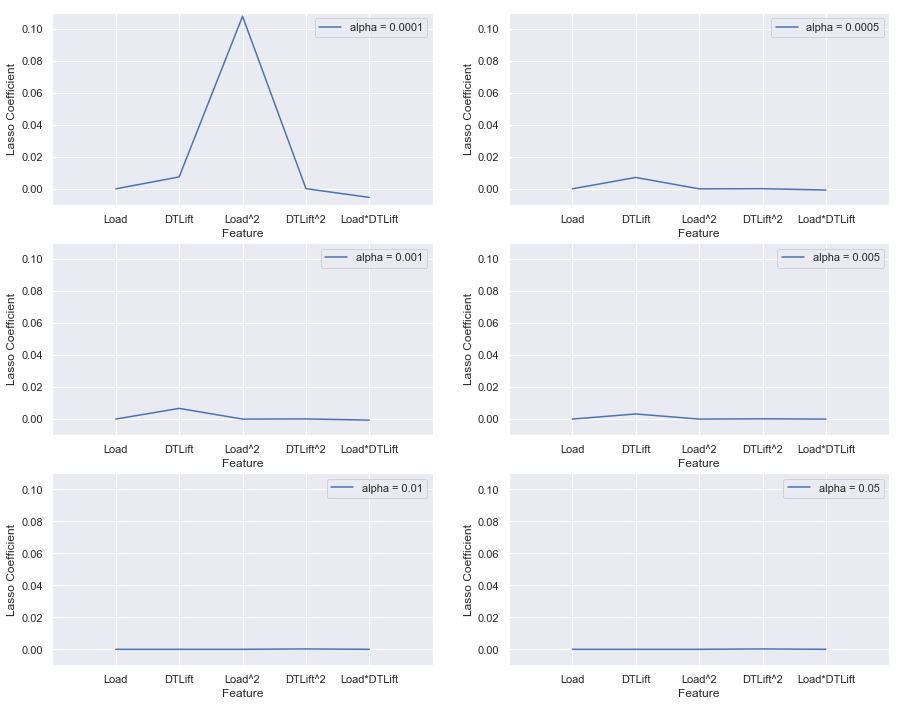

In [686]:
num_features = X_train.shape[1]

p = 0
num_plots = len(lasso_results)
fig, axes = plt.subplots(nrows=(num_plots+1)//2, ncols=2, figsize=(15, int(num_plots/2)*4))

for alpha,score,coef,RMSE in lasso_results:
    #print(alpha,score,coef)
    test = (alpha == 0.7)
    test = True
    plt.setp(axes, xticks=np.linspace(0,num_features+1, num=num_features+2), 
             xticklabels=['','Load','DTLift','Load^2','DTLift^2','Load*DTLift'],
            ylim=(-.01,.11),
            xlim=(0,6))
    if test:
        axes[p//2,p%2].plot(range(1,num_features+1),coef,label=f"alpha = {alpha}")
        axes[p//2,p%2].set_xlabel("Feature")
        axes[p//2,p%2].set_ylabel("Lasso Coefficient")
        axes[p//2,p%2].legend()
      
        p +=1
if num_plots%2 == 1:
    axes[num_plots//2, 1].remove()  # don't display empty plot

plt.show()

## Things to try

Random Forest Regression